In [1]:
import sys
sys.path.insert(0, "/Users/dacostlu/dev/crim-xcs")
print(sys.path)

['/Users/dacostlu/dev/crim-xcs', '', '/anaconda2/envs/python3.6/lib/python36.zip', '/anaconda2/envs/python3.6/lib/python3.6', '/anaconda2/envs/python3.6/lib/python3.6/lib-dynload', '/anaconda2/envs/python3.6/lib/python3.6/site-packages', '/anaconda2/envs/python3.6/lib/python3.6/site-packages/cycler-0.10.0-py3.6.egg', '/Users/dacostlu/dev/gym', '/anaconda2/envs/python3.6/lib/python3.6/site-packages/IPython/extensions', '/Users/dacostlu/.ipython']


In [21]:
import logging
import time
import pickle
import pathlib
import numpy as np

from xcs.algorithms.xcs import XCSAlgorithm
from xcs.framework import ClassifierSet

from xcs.input_encoding.real.scenarios import MUXProblem, MUXScenarioObserver

In [32]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Setup logging so we can see the test run as it progresses.
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
# or:
# logging.root.setLevel(logging.INFO)

# Create the scenario instance
mux_problem = MUXProblem(training_cycles=14000, address_size=3)

# Wrap the scenario instance in an observer so progress gets logged,
mux_scenario = MUXScenarioObserver(mux_problem)
# mux_scenario = ScenarioObserver(mux_problem)
# and pass it on to the test() function.
# xcs.test(scenario=bowling_scenario)
# or do the whole thing in a detailed way:

algorithm = XCSAlgorithm()
# parameters as of original paper:
algorithm.max_population_size = 800          # N
algorithm.learning_rate = .2                # beta
algorithm.accuracy_coefficient = .1          # alpha # page 5 of http://eprints.uwe.ac.uk/5887/1/106365603322365315.pdf
algorithm.error_threshold = 10              # epsilon_0
algorithm.accuracy_power = 5                 # nu # TODO: is this 'n'?
algorithm.ga_threshold = 12                  # theta_GA
algorithm.crossover_probability = .8        # chi
algorithm.mutation_probability = .04         # mu
algorithm.deletion_threshold = 20            # theta_del # page 5 of http://eprints.uwe.ac.uk/5887/1/106365603322365315.pdf
algorithm.fitness_threshold = .1             # delta # page 5 of http://eprints.uwe.ac.uk/5887/1/106365603322365315.pdf
algorithm.subsumption_threshold = 20         # theta_sub # page 5 of http://eprints.uwe.ac.uk/5887/1/106365603322365315.pdf
algorithm.initial_prediction = 10        # p_I # page 5 of http://eprints.uwe.ac.uk/5887/1/106365603322365315.pdf
algorithm.initial_error = 0             # epsilon_I # page 5 of http://eprints.uwe.ac.uk/5887/1/106365603322365315.pdf
algorithm.initial_fitness = .01           # F_I # page 5 of http://eprints.uwe.ac.uk/5887/1/106365603322365315.pdf
algorithm.minimum_actions = 2             # theta_mna # page 5 of http://eprints.uwe.ac.uk/5887/1/106365603322365315.pdf
# algorithm.error_threshold = 1.0              # epsilon_0  # TODO: is this s_0 ?
# we want that, on average, we present exploitation and exploration problems:
algorithm.exploration_probability = .5       # p_exp

# these parameters come from page 5 of http://eprints.uwe.ac.uk/5887/1/106365603322365315.pdf:
algorithm.do_ga_subsumption = True
algorithm.do_action_set_subsumption = False


# discount_factor = .71              # gamma
# fitness_threshold = .1             # delta
# subsumption_threshold = 20         # theta_sub
# wildcard_probability = .33         # P_#

# Create the classifier system from the algorithm.
model = ClassifierSet(algorithm, mux_scenario.get_possible_actions())
start_time = time.time()
model.run(mux_scenario, learn=True)
end_time = time.time()

# logger.info('Classifiers:\n\n%s\n', model)
logger.info("Total time: %.5f seconds", end_time - start_time)


In [56]:
def calculate_stats(dir: str):
    p = pathlib.Path(dir)
    # number of successes
    print("******** number of successes")
    all_results = []
    for filename in list(p.glob('exploit_successes*.txt')):
        with open (filename, 'rb') as fp:
            successes = pickle.load(fp)
            print("file '%s' has a list with %d elements" % (filename, len(successes)))
            all_results.append(successes)
    # prediction errors
    print("******** prediction errors")
    all_prediction_errors = []
    for filename in list(p.glob('error_on_prediction*.txt')):
        with open (filename, 'rb') as fp:
            errors = pickle.load(fp)
            print("file '%s' has a list with %d elements" % (filename, len(errors)))
            all_prediction_errors.append(errors)
    return all_results, all_prediction_errors

In [111]:
def examine_and_plot(dir: str):
    all_results_3, all_prediction_errors_3 = calculate_stats(dir)
    successes = np.mean(all_results_3, axis=0)
    errors = np.mean(all_prediction_errors_3, axis=0)
    plt.rcParams['figure.figsize'] = [10, 5]

    # plt.plot(range(len(successes)), list(map(lambda x: x / 50, successes)), 'b', range(len(errors)), list(map(lambda x: x / (50 * 1000), errors)), 'r--')

    line_up, = plt.plot(list(map(lambda x: x / 50, successes)), 'b', label='Proportion of success')
    line_down, = plt.plot(list(map(lambda x: x / (50 * 1000), errors)), 'r--', label='Prediction errors on reward (/1000)')
    plt.legend(handles=[line_up, line_down], loc='best')
    plt.ylim([0,1])

    for an_x in range(2000, len(successes), 2000):
        plt.axvline(x=an_x, color='y')
    y_ticks = [0.1, 0.2, 0.5, 0.75, 0.8, 0.9, 0.95]
    plt.yticks(y_ticks) # , ('Tom', 'Dick', 'Harry', 'Sally', 'Sue'))
    for an_y in y_ticks:
        plt.axhline(y=an_y, linewidth=0.5, color='y')
    #
    plt.title('Percentage of Success on Exploit Problems\nMean on %d replications' % (len(all_results)))
    plt.xlabel("Exploit problems")
    plt.ylabel("Mean on %d replications" % (len(all_results)))
    plt.show()

## On 2-multiplexer

******** number of successes
file '/tmp/luis/tests/exploit_successes_9.txt' has a list with 9951 elements
file '/tmp/luis/tests/exploit_successes_8.txt' has a list with 9951 elements
file '/tmp/luis/tests/exploit_successes_10.txt' has a list with 9951 elements
file '/tmp/luis/tests/exploit_successes_11.txt' has a list with 9951 elements
file '/tmp/luis/tests/exploit_successes_3.txt' has a list with 9951 elements
file '/tmp/luis/tests/exploit_successes_2.txt' has a list with 9951 elements
file '/tmp/luis/tests/exploit_successes_1.txt' has a list with 9951 elements
file '/tmp/luis/tests/exploit_successes_5.txt' has a list with 9951 elements
file '/tmp/luis/tests/exploit_successes_4.txt' has a list with 9951 elements
file '/tmp/luis/tests/exploit_successes_6.txt' has a list with 9951 elements
file '/tmp/luis/tests/exploit_successes_7.txt' has a list with 9951 elements
******** prediction errors
file '/tmp/luis/tests/error_on_prediction_2.txt' has a list with 9951 elements
file '/tmp/luis/

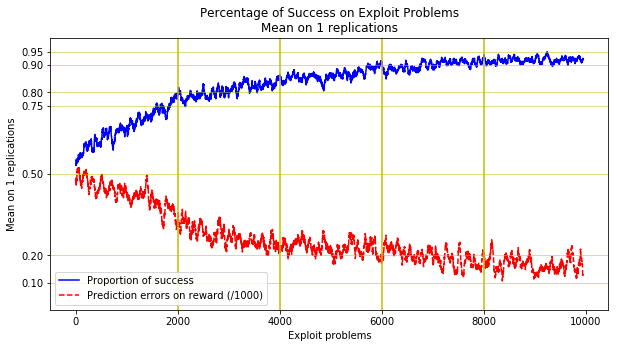

In [112]:
examine_and_plot(dir = '/tmp/luis/tests')

## On 3-multiplexer

******** number of successes
file '/tmp/luis/tests/multi/3/5000/exploit_successes_1.txt' has a list with 9951 elements
******** prediction errors
file '/tmp/luis/tests/multi/3/5000/error_on_prediction_1.txt' has a list with 9951 elements


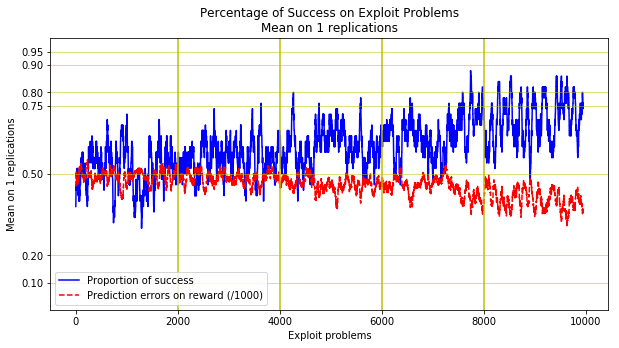

In [113]:
examine_and_plot(dir = '/tmp/luis/tests/multi/3/5000')

******** number of successes
file '/tmp/luis/tests/multi/3/exploit_successes_2.txt' has a list with 9951 elements
file '/tmp/luis/tests/multi/3/exploit_successes_1.txt' has a list with 9951 elements
******** prediction errors
file '/tmp/luis/tests/multi/3/error_on_prediction_2.txt' has a list with 9951 elements
file '/tmp/luis/tests/multi/3/error_on_prediction_1.txt' has a list with 9951 elements


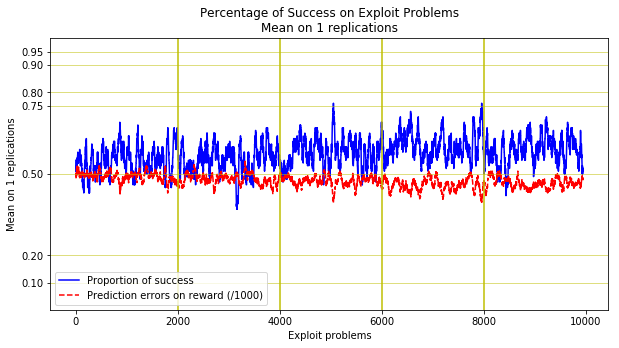

In [114]:
examine_and_plot(dir = '/tmp/luis/tests/multi/3')
